In [55]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, 'data')

reference_colors = np.array([
    [1, 4, 42],    # Very dark blue
    [0, 106, 78],  # Dark teal
    [124, 250, 0], # Bright yellow-green
    [241, 215, 27],# Mustard yellow
    [255, 0, 0]    # Pure red
])

def select_images(lake_name: str, type: str, max_images: int , from_date: datetime, to_date: datetime = datetime.now()):
    current_date = from_date
    selected_files = []
    while current_date < to_date:
        current_date_str = current_date.strftime('%Y-%m-%d')
        file_name = f"{lake_name}_{type}_{current_date_str}.npy"
        file_path = os.path.join(data_dir, file_name)
        if os.path.isfile(file_path):
            selected_files.append(file_path)
        current_date += timedelta(days = 1)

    return selected_files
  
    

# Function to categorize a pixel
def categorize_pixel(pixel, reference_colors):
    # Only consider the RGB part of the pixel
    distances = np.linalg.norm(reference_colors - pixel[:3], axis=1)
    return np.argmin(distances)

def calculate_MCI(lake_name: str, date: datetime = datetime(2020, 1, 1))->float:
    lake_name = lake_name.lower().replace(" ", "_")
    date_str = date.strftime('%Y-%m-%d')
    ndwi_file_name = lake_name + "_ndwi_" + date_str + ".npy"
    
    # Water_area
    water_image = np.load(os.path.join(data_dir, ndwi_file_name))
    lake_area = calculate_area(water_image)

    # Chlorophill area
    chlorophyll_file_name = lake_name + "_blackbg_chlorophyll_" + date_str + ".npy"
    chlorophyll_image = np.load(os.path.join(data_dir, chlorophyll_file_name))
    chlorophill_area = calculate_chlorophyll_area(chlorophyll_image)

    mci = get_MCI(chlorophyll_image)
    print("""\t Lake name: \t {}
          Date: {}
          MCI: {}

          ----------------------------------------
          
          """.format(lake_name, date_str, mci))
    return mci



def calculate_area(water_image: np.ndarray, pixel_length: int = 5,pixel_width : int = 5)->int:
    
    total_pixels_count = water_image.shape[0] * water_image.shape[1]
    blue_pixels_mask = (water_image[:, :, 2] > water_image[:, :, 0]) & (water_image[:, :, 2] > water_image[:, :, 1]) & (water_image[:, :, 3] != 0)
    blue_pixels_count = np.sum(blue_pixels_mask)
    water_pixels_area = blue_pixels_count * pixel_length * pixel_width

    return water_pixels_area

def calculate_chlorophyll_area(loaded_image:np.ndarray, pixel_length: int = 5,pixel_width : int = 5):
    total_pixels_count = loaded_image.shape[0] * loaded_image.shape[1]
    black_pixels_mask = np.all(loaded_image[:, :, :3] == [0, 0, 0], axis=-1) & (loaded_image[:, :, 3] != 0)
    black_pixels_count = np.sum(black_pixels_mask)
    non_black_pixels_count = total_pixels_count - black_pixels_count
    chlorophyll_area = non_black_pixels_count * pixel_length * pixel_width

    return chlorophyll_area

def get_MCI(loaded_image:np.ndarray, pixel_length: int = 5,pixel_width : int = 5):
    total_pixels_count = loaded_image.shape[0] * loaded_image.shape[1]
    black_pixels_mask = np.all(loaded_image[:, :, :3] == [0, 0, 0], axis=-1) & (loaded_image[:, :, 3] != 0)

    # Define non-black pixels mask
    non_black_pixels_mask = ~black_pixels_mask

    # Get all non-black pixels
    non_black_pixels = loaded_image[non_black_pixels_mask]

    # Reshape the non-black pixels array to have the same number of channels as the original image
    non_black_pixels = non_black_pixels.reshape(-1, loaded_image.shape[2])

    categorized_pixels = [categorize_pixel(pixel, reference_colors) for pixel in non_black_pixels]

    # Initialize an array to store the category of each pixel
    categories = np.zeros((loaded_image.shape[0], loaded_image.shape[1]), dtype=int)

    # Assign categories back to the original image shape
    categories[non_black_pixels_mask] = categorized_pixels
    
    category_counts = np.bincount(categorized_pixels, minlength=len(reference_colors))

    concentration_values = np.array([0, 0.0125, 0.0250, 0.0375, 0.05])

    total_concentration = np.sum(category_counts * concentration_values)
    total_volume = total_concentration * pixel_length * pixel_width
    return total_volume


    







    


In [56]:
date = datetime(2020, 1, 1)

dates = []
mcis = []
for i in range(4):
    mci = calculate_MCI("Sukhna Lake", date)
    dates.append(date)
    mcis.append(mci)
    date += relativedelta(months = 1)

df = pd.DataFrame({'date': dates, 'mci': mcis})
df.head()




	 Lake name: 	 sukhna_lake
          Date: 2020-01-01
          MCI: 27981.25

          ----------------------------------------
          
          
	 Lake name: 	 sukhna_lake
          Date: 2020-02-01
          MCI: 0.0

          ----------------------------------------
          
          
	 Lake name: 	 sukhna_lake
          Date: 2020-03-01
          MCI: 0.0

          ----------------------------------------
          
          
	 Lake name: 	 sukhna_lake
          Date: 2020-04-01
          MCI: 35932.5

          ----------------------------------------
          
          


,date,mci
0,2020-01-01,27981.25
1,2020-02-01,0.00
2,2020-03-01,0.00
3,2020-04-01,35932.50


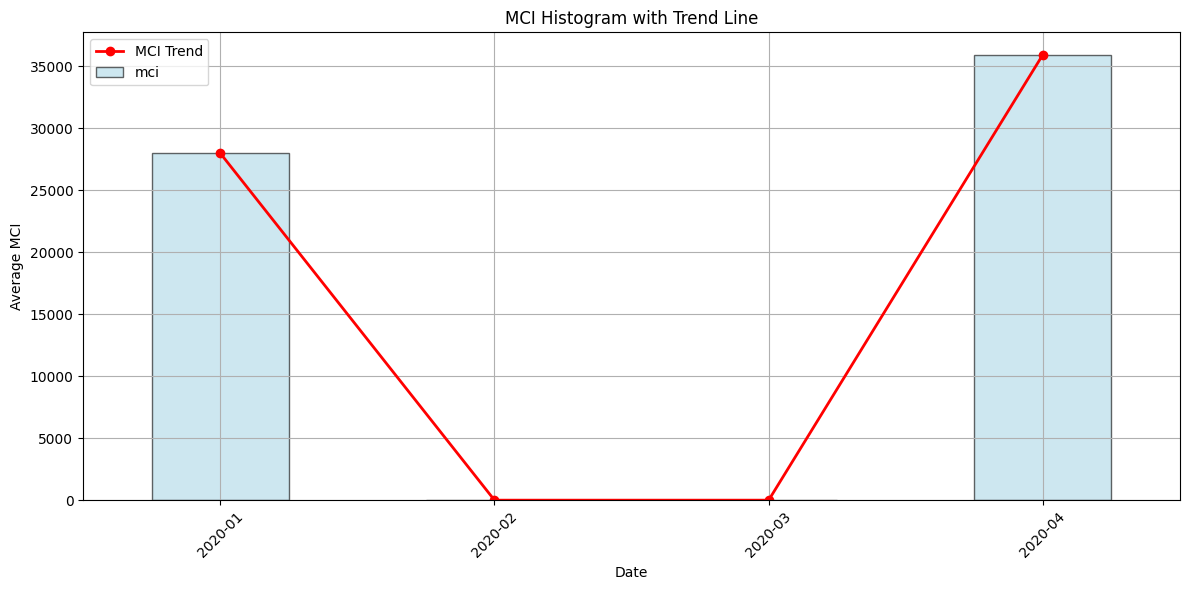

In [60]:
def plot_history_mci(df: pd.DataFrame):
    fig, ax1 = plt.subplots(figsize=(12, 6))

# Graficar el histograma
# Agrupar los datos por fecha y contar las frecuencias
    df['month'] = df['date'].dt.to_period('M').astype(str)
    hist_data = df.groupby('month')['mci'].mean()

    # Graficar el histograma de medias de mci
    hist = hist_data.plot(kind='bar', color='lightblue', edgecolor='black', alpha=0.6, ax=ax1)

    # Conectar los puntos con una línea
    ax1.plot(hist_data.index, hist_data.values, marker='o', color='red', linestyle='-', linewidth=2, markersize=6, label='MCI Trend')

    # Configurar etiquetas y título
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Average MCI')
    ax1.set_title('MCI Histogram with Trend Line')

    # Mejorar la visualización de las fechas en el eje x
    plt.xticks(rotation=45)
    ax1.set_xticks(hist_data.index)  # Asegurarse de que las etiquetas del eje x están bien posicionadas

    # Añadir leyenda
    ax1.legend()

    # Mostrar la gráfica
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_history_mci(df)